<a href="https://colab.research.google.com/github/sravan1320/Big-Mart-Sales-Prediction/blob/master/Big_Mart_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn import preprocessing as pre
from sklearn.preprocessing import PolynomialFeatures

from collections import Collection

import warnings
warnings.filterwarnings('ignore')
le = pre.LabelEncoder()

In [0]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [0]:
TrainData=pd.read_csv("Train.txt",",")
TestData=pd.read_csv("Test.txt",",")

In [4]:
TrainData.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
TrainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [6]:
TrainData.describe(include="all")

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [7]:
TrainData.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
corr=TrainData.corr()**2
corr

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,0.000197,0.000737,0.000134,0.000199
Item_Visibility,0.000197,1.000000,0.000002,0.005600,0.016544
Item_MRP,0.000737,0.000002,1.000000,0.000025,0.322141
Outlet_Establishment_Year,0.000134,0.005600,0.000025,1.000000,0.002414
Item_Outlet_Sales,0.000199,0.016544,0.322141,0.002414,1.000000


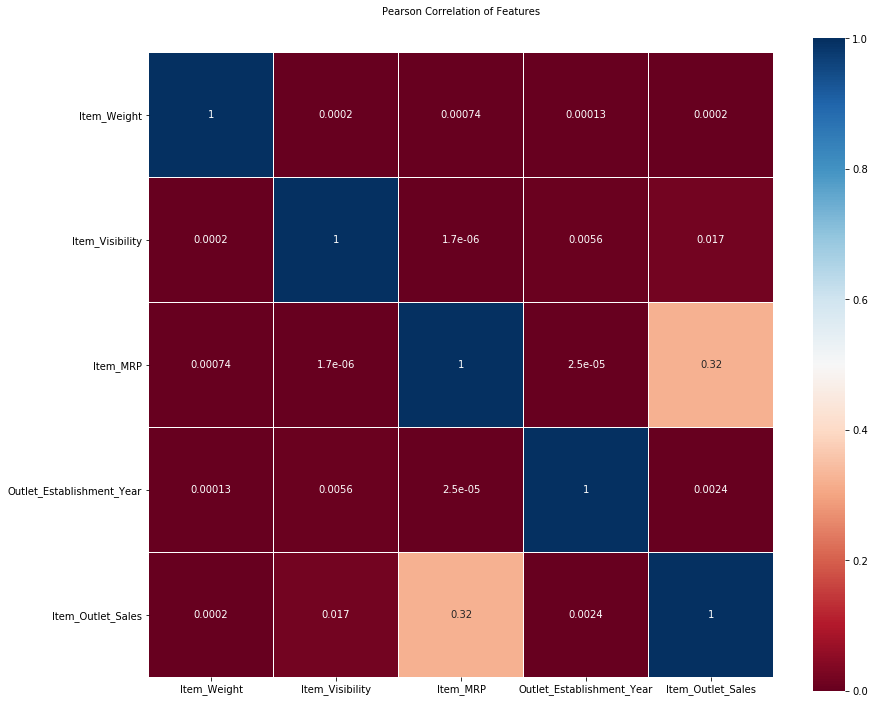

In [9]:

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=10)
sns.heatmap(corr,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [10]:
uniqueSet={}
def GetUniqueValues(df):
  for i in df.columns:
    uniqueSet[i]=df[i].unique()
  return uniqueSet

GetUniqueValues(TrainData)


{'Item_Fat_Content': array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object),
 'Item_Identifier': array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
       dtype=object),
 'Item_MRP': array([249.8092,  48.2692, 141.618 , ...,  57.5904, 214.5218,  75.467 ]),
 'Item_Outlet_Sales': array([3735.138 ,  443.4228, 2097.27  , ..., 7182.6504, 3608.636 ,
        2778.3834]),
 'Item_Type': array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
        'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
        'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
        'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object),
 'Item_Visibility': array([0.0160473 , 0.01927822, 0.01676007, ..., 0.03518627, 0.14522065,
        0.04487828]),
 'Item_Weight': array([ 9.3  ,  5.92 , 17.5  , 19.2  ,  8.93 , 10.395, 13.65 ,    nan,
        16.2  , 11.8  , 18.5  , 15.1  , 17.6  , 16.35 ,  9.   , 13.35 ,
        18.85 , 14.6  , 13.85 , 13.   ,  7.64

In [11]:
TrainData.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [0]:
#Outlier Treatment
TrainData['Item_Visibility'][TrainData['Item_Visibility']>=0.17637255]=0.17637255
TrainData['Item_Visibility'][TrainData['Item_Visibility']==0]=0.0035747

TestData['Item_Visibility'][TestData['Item_Visibility']>=0.17637255]=0.17637255
TestData['Item_Visibility'][TestData['Item_Visibility']==0]=0.0035747


In [13]:
import sys
np.set_printoptions(threshold=sys.maxsize)
np.percentile(TrainData['Item_Visibility'], [  95,96,97,98,99,100])
                                       
# 0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]

array([0.16377976, 0.17128795, 0.17635928, 0.17637255, 0.17637255,
       0.17637255])

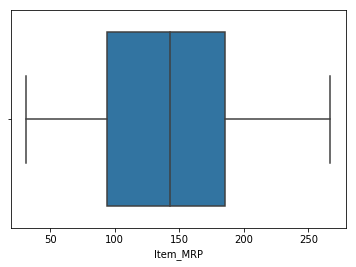

In [14]:
#Outlier Detction
sns.boxplot(TrainData['Item_MRP'])
plt.show()

In [0]:
# Feature Engineering
#From Unique we can see Item_Fat_Content has duplicate values
# 'Low Fat', 'Regular', '', 'LF', 'reg'
TrainData['Item_Fat_Content'][TrainData['Item_Fat_Content']=='low fat']='Low Fat'
TrainData['Item_Fat_Content'][TrainData['Item_Fat_Content']=='LF']='Low Fat'
TrainData['Item_Fat_Content'][TrainData['Item_Fat_Content']=='reg']='Regular'

TestData['Item_Fat_Content'][TestData['Item_Fat_Content']=='low fat']='Low Fat'
TestData['Item_Fat_Content'][TestData['Item_Fat_Content']=='LF']='Low Fat'
TestData['Item_Fat_Content'][TestData['Item_Fat_Content']=='reg']='Regular'




In [0]:
#New Feature Creation
TrainData['Outlet_Age']=2019-TrainData['Outlet_Establishment_Year']

TestData['Outlet_Age']=2019-TestData['Outlet_Establishment_Year']
# TrainData['Outlet_Age']

# Found Item_Identifier F, D, N with unique values excpect Dairy so for Item_Identifier in (F, D) and item_type='Dairy' creating new value
TrainData['Item_Identifier_Type'] = TrainData['Item_Identifier'].apply(lambda x: 1 if x.startswith('F') else (2 if x.startswith('D') else (3 if x.startswith('N') else 0)))

TrainData['Item_Identifier_Type'][(TrainData['Item_Identifier'].str.startswith('F')) & (TrainData['Item_Type']=='Dairy')]=4
TrainData['Item_Identifier_Type'][(TrainData['Item_Identifier'].str.startswith('D')) & (TrainData['Item_Type']=='Dairy')]=5


TestData['Item_Identifier_Type'] = TestData['Item_Identifier'].apply(lambda x: 1 if x.startswith('F') else (2 if x.startswith('D') else (3 if x.startswith('N') else 0)))

TestData['Item_Identifier_Type'][(TestData['Item_Identifier'].str.startswith('F')) & (TestData['Item_Type']=='Dairy')]=4
TestData['Item_Identifier_Type'][(TestData['Item_Identifier'].str.startswith('D')) & (TestData['Item_Type']=='Dairy')]=5

In [0]:
#Assumption
# 1) Sales depends upon MRP
# 2) Sales depends upon Visibility
# 3) Sales depends upon OUtlet Size
# 4) Sales depends upon Outlet Type
# 5) Sales depends upon Outlet Location
# 6) Mostly Fruits & Veg & HOuse hold items will sale
# 7) People purchasing Low Fat items
# 8) WHich product selling more, in all outlets most selling items are fruits & vegetables, snacks, household & Dairy etc
# 9) WHich Outlets comes under which tier

In [18]:
TrainData.columns


Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Outlet_Age',
       'Item_Identifier_Type'],
      dtype='object')

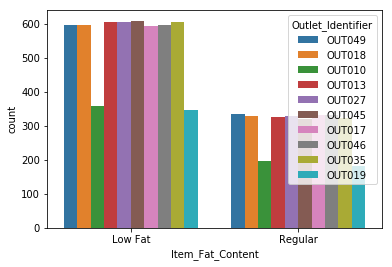

In [19]:
sns.countplot('Item_Fat_Content', hue='Outlet_Identifier',data=TrainData)
plt.show()

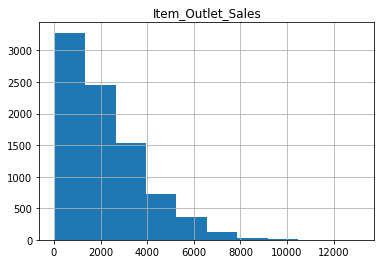

In [20]:
 TrainData.hist('Item_Outlet_Sales', bins=10)
 plt.show()

In [21]:
# WHich Outlet Comes under which Location & Type & Size & Establishment Year
TrainData[['Outlet_Identifier', 'Outlet_Location_Type','Outlet_Type','Outlet_Size','Outlet_Establishment_Year']].drop_duplicates()


,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Outlet_Size,Outlet_Establishment_Year
0,OUT049,Tier 1,Supermarket Type1,Medium,1999
1,OUT018,Tier 3,Supermarket Type2,Medium,2009
3,OUT010,Tier 3,Grocery Store,NaN,1998
4,OUT013,Tier 3,Supermarket Type1,High,1987
7,OUT027,Tier 3,Supermarket Type3,Medium,1985
8,OUT045,Tier 2,Supermarket Type1,NaN,2002
9,OUT017,Tier 2,Supermarket Type1,NaN,2007
11,OUT046,Tier 1,Supermarket Type1,Small,1997
19,OUT035,Tier 2,Supermarket Type1,Small,2004
23,OUT019,Tier 1,Grocery Store,Small,1985


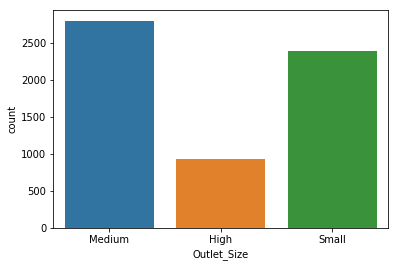

In [22]:
sns.countplot('Outlet_Size', data=TrainData)
plt.show()

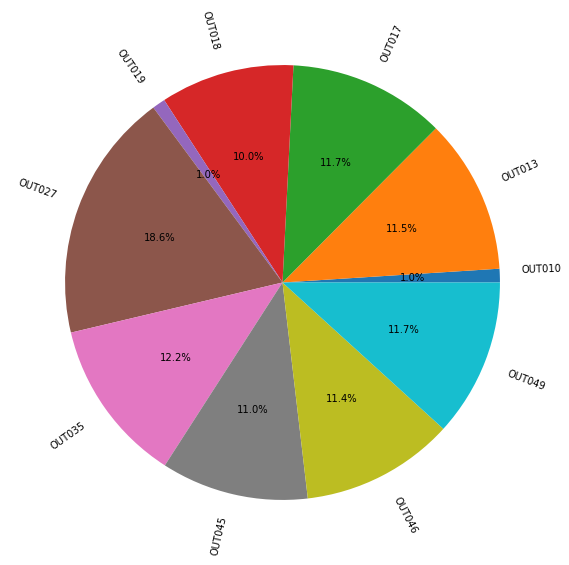

In [23]:
# Pie Chart for OUtlet on sum of sales
# if we an observe here OutLet 27 has highest sales, it is  tier3, Supermarket TYpe3 , Medium , 1985
sums = TrainData['Item_Outlet_Sales'].groupby(TrainData['Outlet_Identifier']).sum().reset_index(name='Sales')
# sums
plt.figure(figsize=(10,10))
plt.pie(sums['Sales'], labels=sums['Outlet_Identifier'], rotatelabels=True,autopct='%1.1f%%');
plt.show()

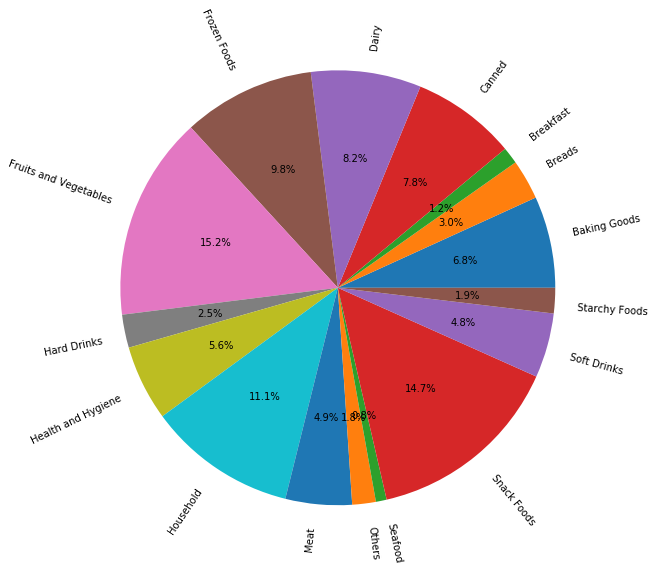

In [24]:
# Pie Chart for Each and every product wise sales
sums = TrainData['Item_Outlet_Sales'].groupby(TrainData['Item_Type']).sum().reset_index(name='Sales')
# sums
plt.figure(figsize=(10,10))
plt.pie(sums['Sales'], labels=sums['Item_Type'], rotatelabels=True,autopct='%1.1f%%');
plt.show()

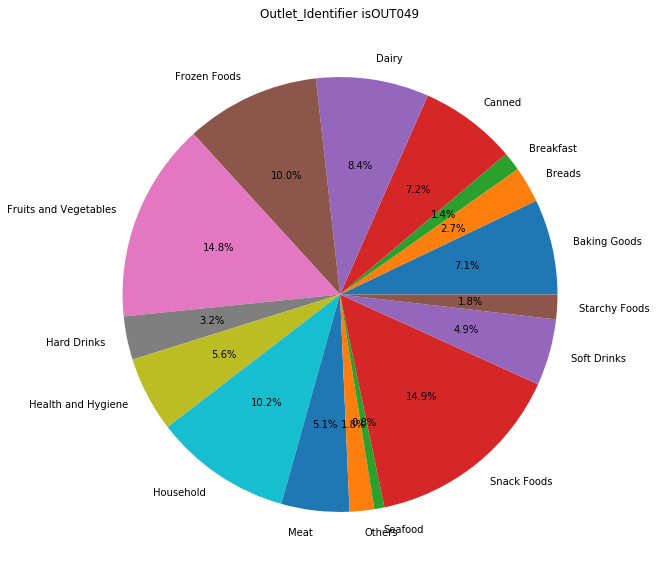

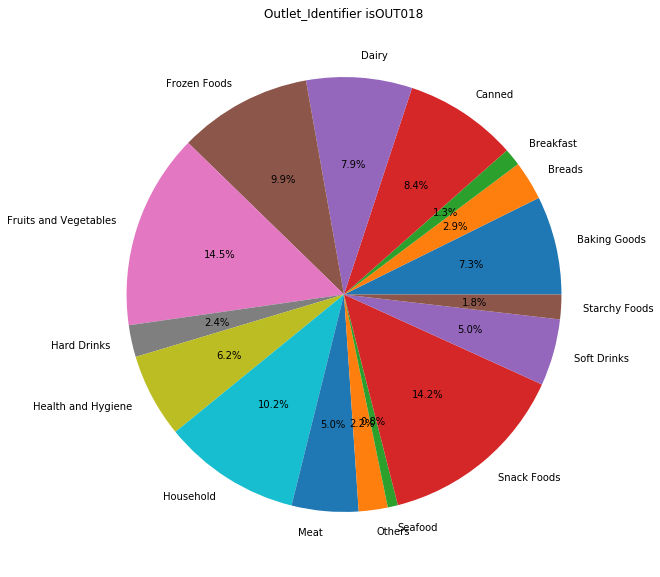

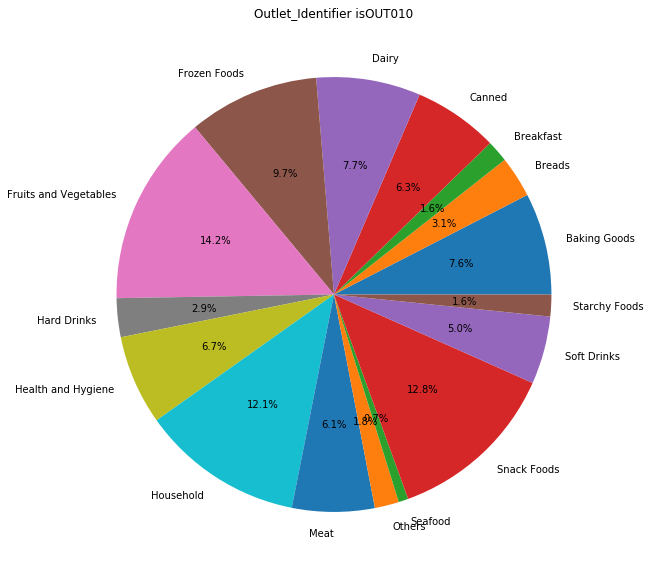

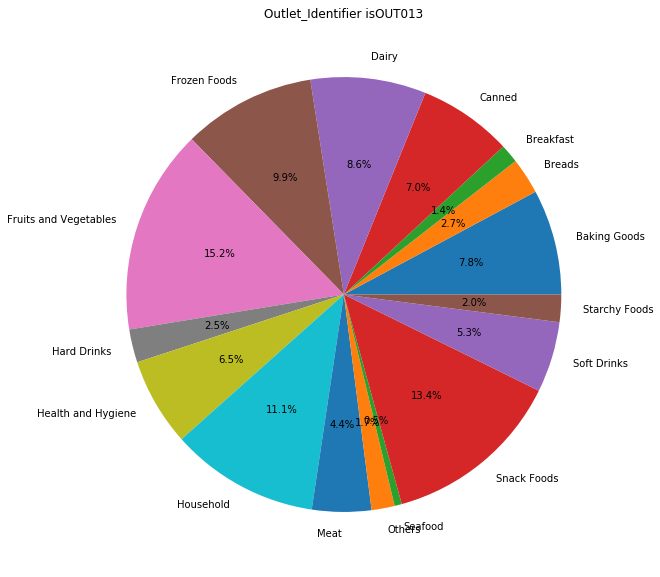

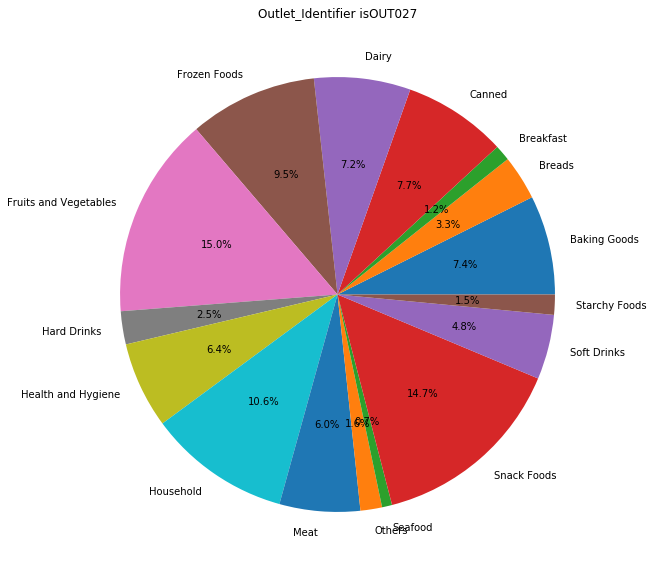

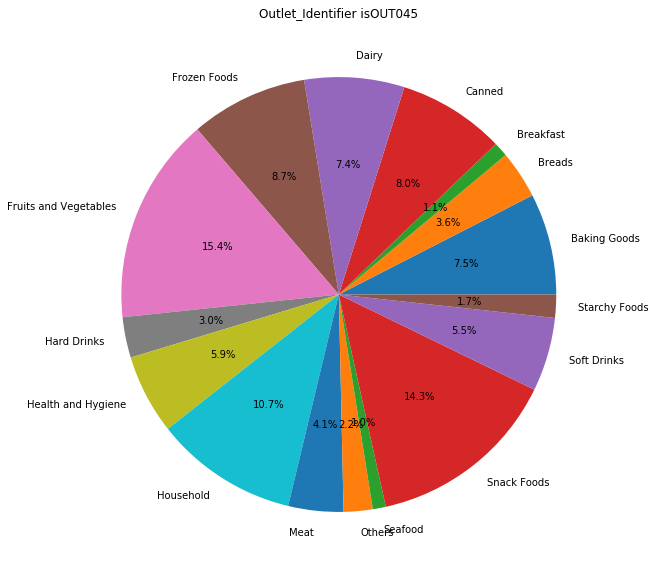

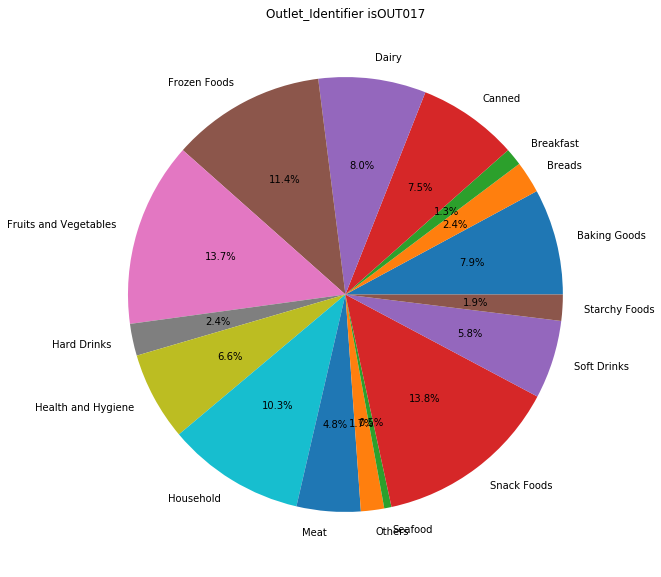

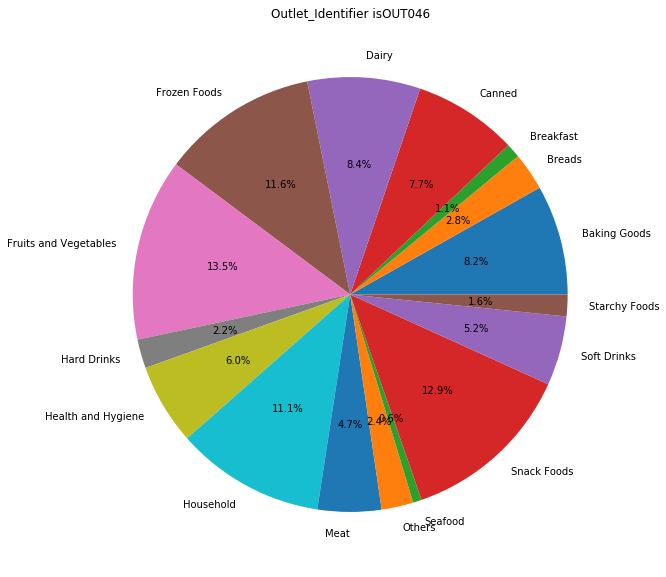

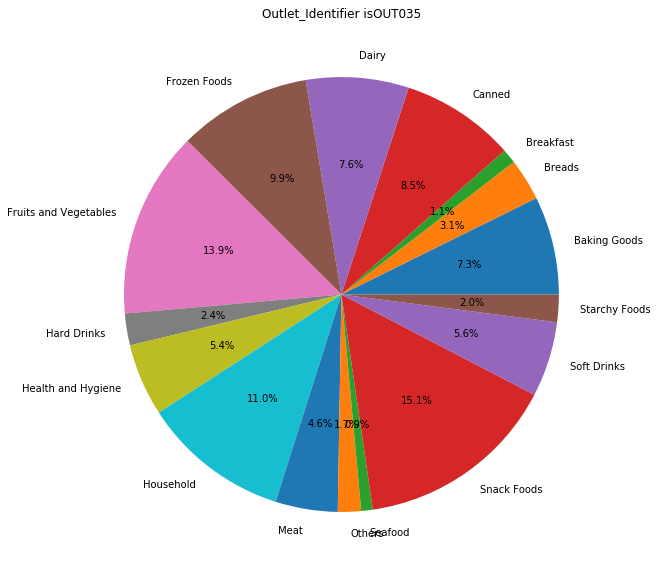

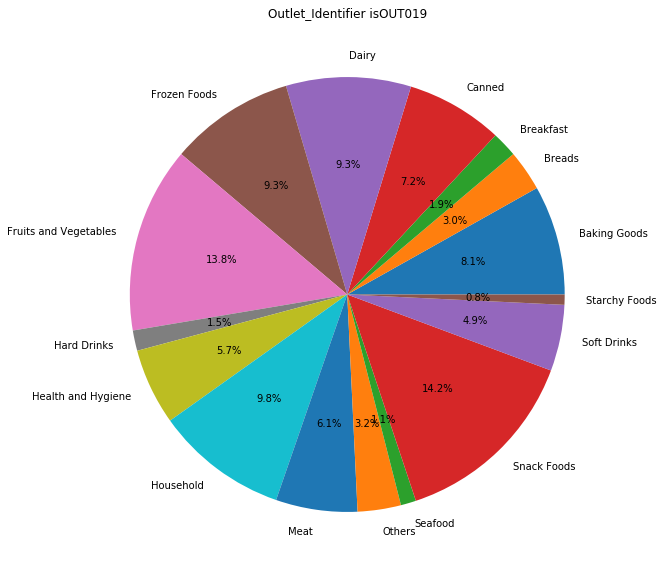

In [25]:
# Pie Chart for Each and Outlet wise and product wise sales
# Check what type of items in each and every OUtlet
for i in TrainData['Outlet_Identifier'].unique():
  # print(i)
  df=TrainData[TrainData['Outlet_Identifier']==i]
  sums = df['Item_Outlet_Sales'].groupby(df['Item_Type']).count().reset_index(name='Sales')
  plt.figure(figsize=(10,10))
  plt.title('Outlet_Identifier is'+ i)
  plt.pie(sums['Sales'], labels=sums['Item_Type'], rotatelabels=False,autopct='%1.1f%%');
  plt.show()
  # break;

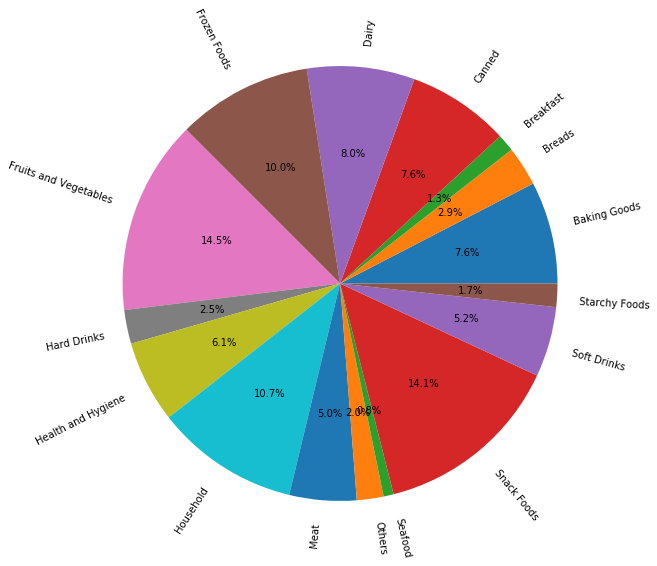

In [26]:
# Pie Chart for Item Type
sums = TrainData['Item_Type'].groupby(TrainData['Item_Type']).count().reset_index(name='counts')
# sums
plt.figure(figsize=(10,10))
plt.pie(sums['counts'], labels=sums['Item_Type'], rotatelabels=True,autopct='%1.1f%%');
plt.show()

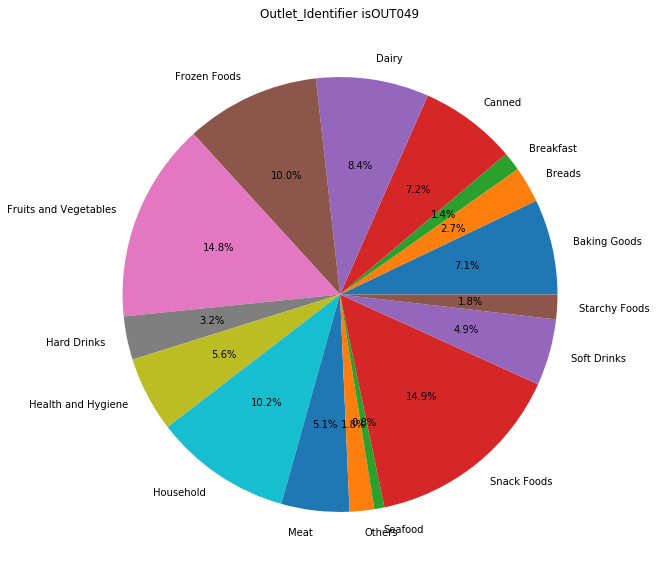

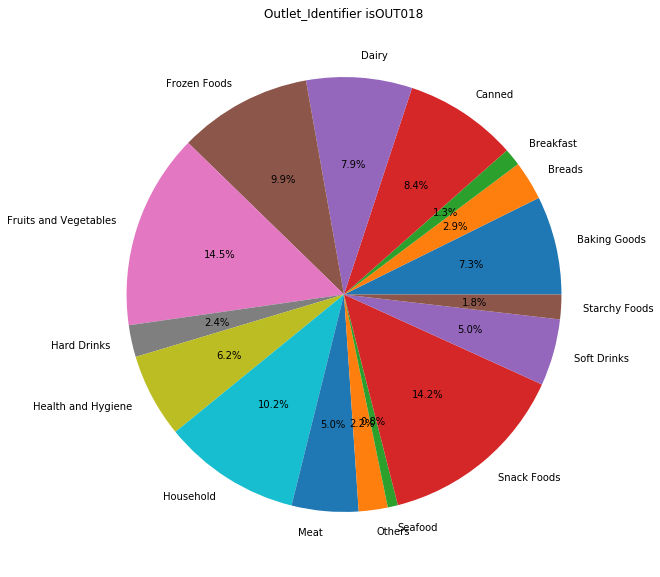

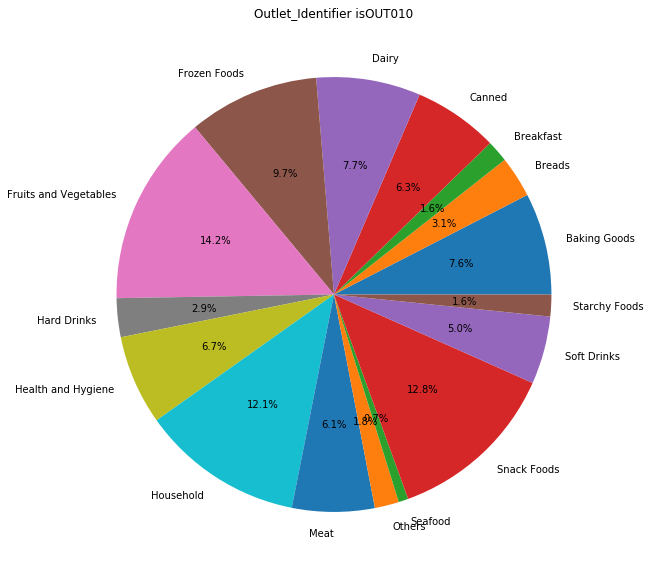

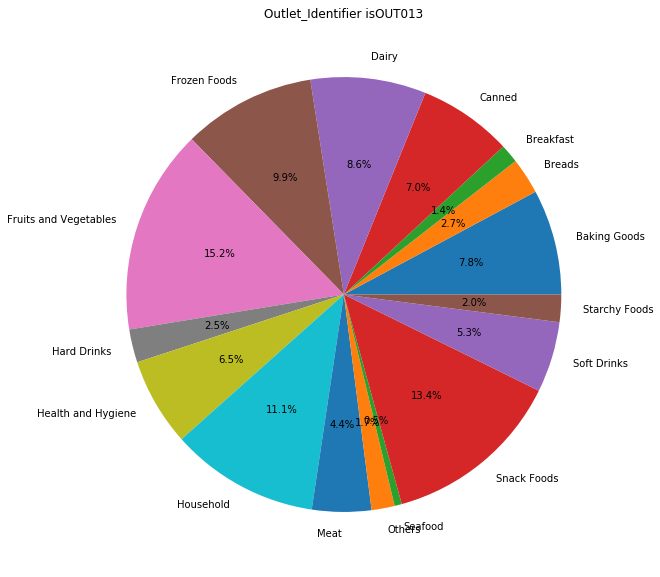

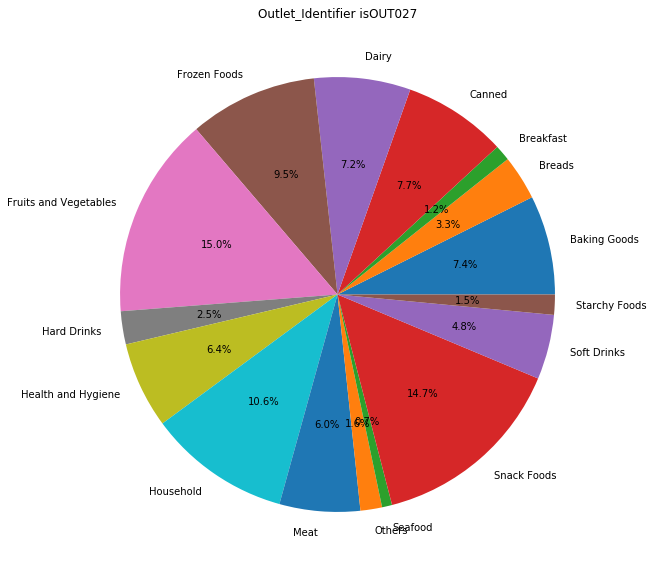

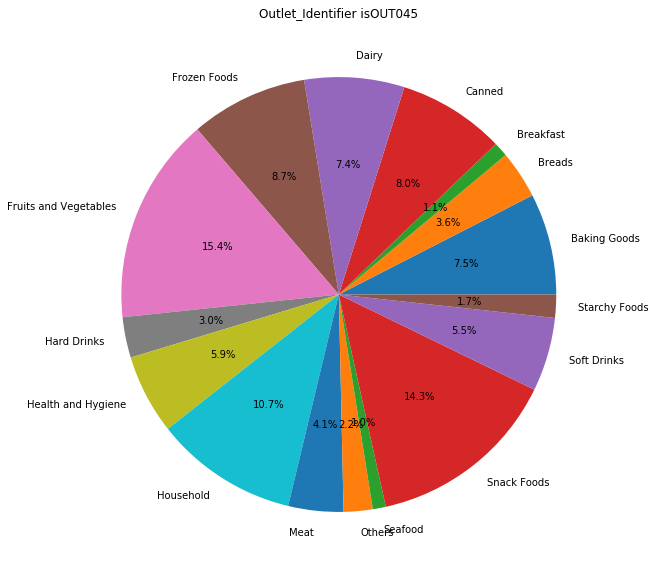

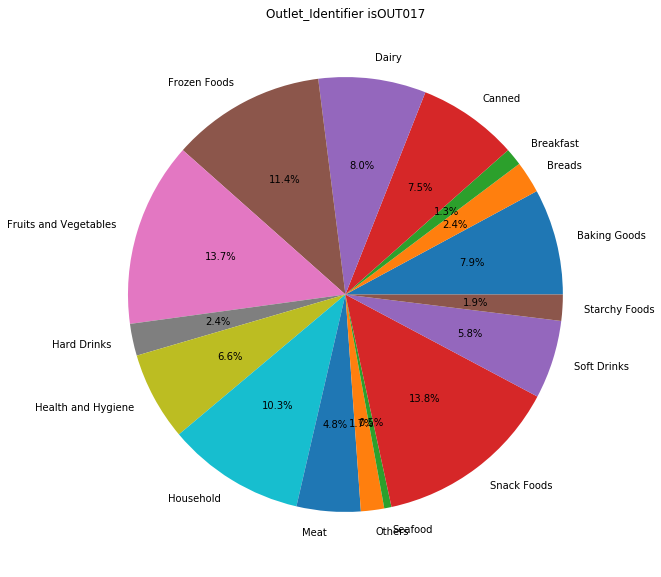

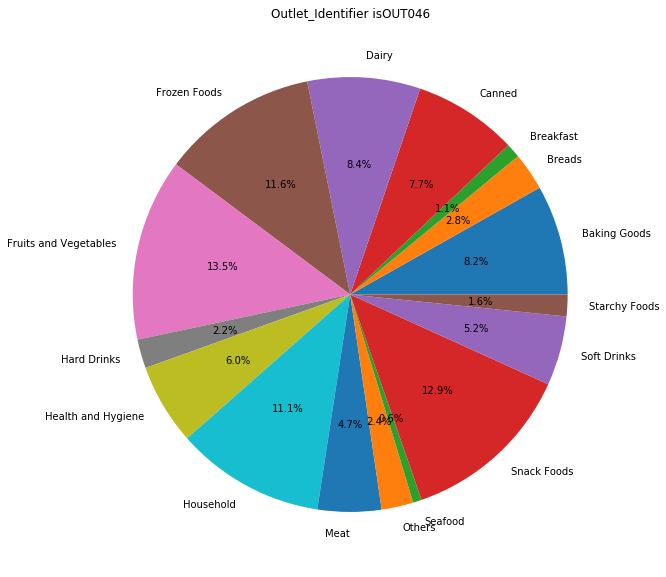

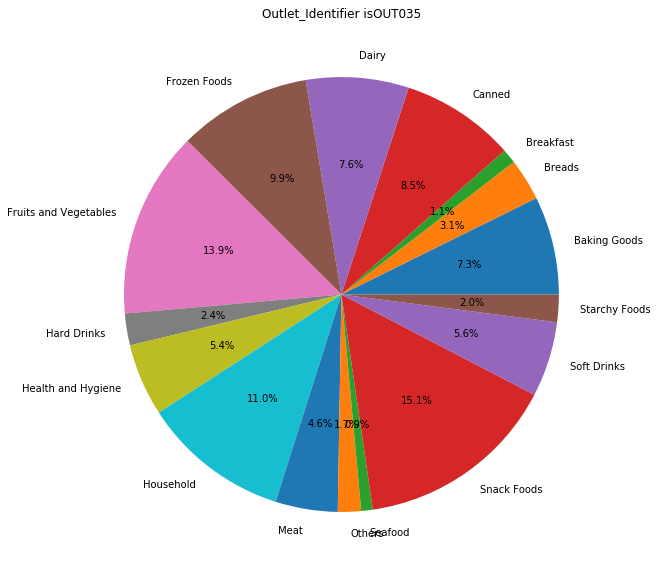

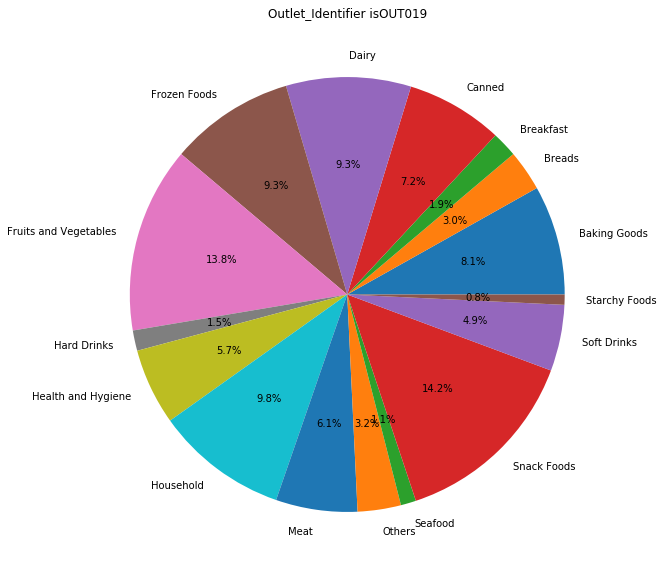

In [27]:
# Check what type of items in each and every OUtlet
for i in TrainData['Outlet_Identifier'].unique():
  # print(i)
  df=TrainData[TrainData['Outlet_Identifier']==i]
  sums = df['Item_Type'].groupby(df['Item_Type']).count().reset_index(name='counts')
  # print(sums)
  # plt.legend(sums['counts'], sums['Item_Type'], loc="best")
  plt.figure(figsize=(10,10))
  plt.title('Outlet_Identifier is'+ i)
  plt.pie(sums['counts'], labels=sums['Item_Type'], rotatelabels=False,autopct='%1.1f%%');
  plt.show()
  # break;

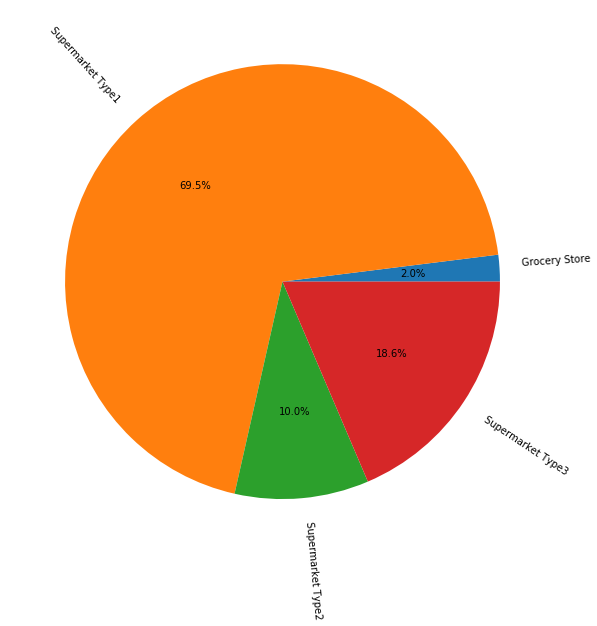

In [28]:
# Verify whether based on outlet Type sales 
sums = TrainData['Item_Outlet_Sales'].groupby(TrainData['Outlet_Type']).sum().reset_index(name='Sales')
# sums
plt.figure(figsize=(10,10))
plt.pie(sums['Sales'], labels=sums['Outlet_Type'], rotatelabels=True,autopct='%1.1f%%');
plt.show()

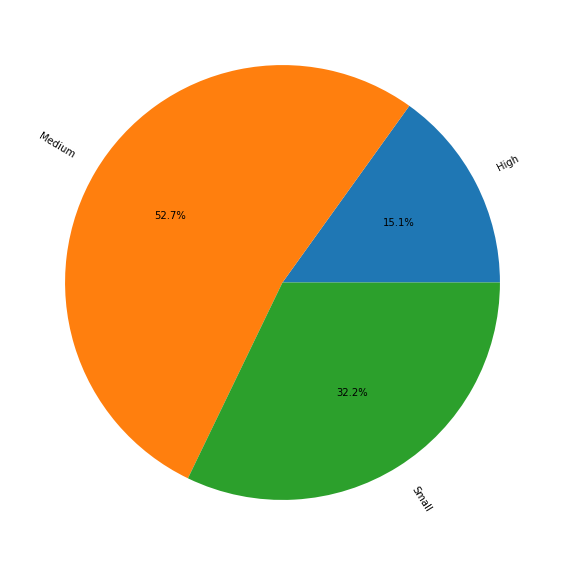

In [29]:
# Verify whether based on outlet size sales 
sums = TrainData['Item_Outlet_Sales'].groupby(TrainData['Outlet_Size']).sum().reset_index(name='Sales')
# sums
plt.figure(figsize=(10,10))
plt.pie(sums['Sales'], labels=sums['Outlet_Size'], rotatelabels=True,autopct='%1.1f%%');
plt.show()

In [0]:
#Impute missing values
# Impute Weight based on Group by Pattern of item , type, fat
TrainData1=TrainData.copy()
TestData1=TestData.copy()

TrainData1["Item_Weight"] = TrainData1.groupby(['Item_Identifier','Item_Type','Item_Fat_Content'])['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
TrainData1['Item_Weight'].fillna(TrainData1['Item_Weight'].mean(), inplace=True)


TestData1["Item_Weight"] = TestData1.groupby(['Item_Identifier','Item_Type','Item_Fat_Content'])['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
TestData1['Item_Weight'].fillna(TestData1['Item_Weight'].mean(), inplace=True)

TrainData1["Outlet_Size"] = TrainData1.groupby(['Outlet_Location_Type','Outlet_Type'],as_index=False)['Outlet_Size'].transform(lambda x: x.fillna(x.ffill()))
TrainData1['Outlet_Size'].fillna(TrainData1['Outlet_Size'].mode()[0], inplace=True)

TestData1["Outlet_Size"] = TestData1.groupby(['Outlet_Location_Type','Outlet_Type'],as_index=False)['Outlet_Size'].transform(lambda x: x.fillna(x.ffill()))
TestData1['Outlet_Size'].fillna(TestData1['Outlet_Size'].mode()[0], inplace=True)


In [0]:
# Handling Category variable
def LabelEncode(df):
    for i in df.columns:
        if(df[i].dtypes=='object'):
           df[i] = le.fit_transform(df[i])
LabelEncode(TrainData1)

In [39]:
X=TrainData1.drop(['Item_Outlet_Sales'], axis=1)
Y=TrainData1[['Item_Outlet_Sales']].values.ravel()

print(X.shape)
print(Y.shape)

X_Train,X_Test,Y_Train,Y_Test=train_test_split(X,Y, test_size=0.2, random_state=30, shuffle=True)

print(X_Train.shape)
print(X_Test.shape)
print(Y_Train.shape)
print(Y_Test.shape)

(8523, 13)
(8523,)
(6818, 13)
(1705, 13)
(6818,)
(1705,)


In [106]:
X1 = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns)

TestData_New=TestData1.copy()

le = pre.LabelEncoder()

for i in TestData_New.columns:
    # print(i)
    if(TestData_New[i].dtypes=='object'):
        TestData_New[i] = le.fit_transform(TestData_New[i])

TestData_New = pd.DataFrame(RobustScaler().fit_transform(TestData_New), columns=TestData_New.columns)

TestData_New['Item_Identifier1']=TestData1['Item_Identifier']
TestData_New['Outlet_Identifier1']=TestData1['Outlet_Identifier']
        
gb=GradientBoostingRegressor(alpha=0.999, criterion='friedman_mse', init=None,
                          learning_rate=0.061, loss='huber', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=102,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

np.set_printoptions(threshold=100)
gb.fit(X1,Y)
pred=gb.predict(TestData_New.drop(['Item_Identifier1','Outlet_Identifier1'], axis=1))
print(pred)
TestData_New['Item_Outlet_Sales']=pred

[1499.82437874 1437.26409678  585.15763792 ... 1963.1751792  3604.00005012
 1264.6603326 ]


In [0]:
TestData_New['Item_Identifier']=TestData_New['Item_Identifier1']
TestData_New['Outlet_Identifier']=TestData_New['Outlet_Identifier1']
testdv=TestData_New[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
testdv.to_csv('Submission_GB_1_15-Oct-2019.csv',index=False)


In [0]:

TestData_New.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier1,Outlet_Identifier1,Item_Outlet_Sales
0,FDW58,20.750,0,0.007565,13,107.8622,OUT049,1999,1,0,1,FDW58,OUT049,1637.139715
1,FDW14,8.300,1,0.038428,4,87.3198,OUT017,2007,2,1,1,FDW14,OUT017,1416.706847
2,NCN55,14.600,0,0.099575,11,241.7538,OUT010,1998,2,2,0,NCN55,OUT010,623.555562
3,FDQ58,7.315,0,0.015388,13,155.0340,OUT017,2007,2,1,1,FDQ58,OUT017,2532.585607
4,FDY38,13.600,1,0.118599,4,234.2300,OUT027,1985,1,2,3,FDY38,OUT027,5913.400546
